In [3]:
%%html
<style>
table {float:left}
</style>

# Holdout data Evaluation
- [import libraries](#training-log)
- [read holdout data](#read-data)
- [preprocessing holdout data](#preprocessing-holdout-data)
- [feature engineering](#feature-engineering)
- [aggregating features](#feature-aggregation)
- [prediction and evaluation](#prediction-and-evaluation)

## Importing Libraries

The following table lists version information of packages used in this notebook.
***Please make sure the file 'modules.py' is located in the same directory as this file***

| Package  | Version |
| ------------- | ------------- |
| pandas  | 0.24.2  |
| numpy  | 1.16.2  |
| sklearn  | 0.20.3  |
| matplotlib  | 3.0.3  |

In [4]:
from funs import * #<---- custom file in same directory with functions

## Reading Holdout data

This notebook file resides in the root folder. Please place the holdout data files in the ***holdout*** folder and label file in the ***holdoutlabel*** folder. The structure required is as given below. Please rename the label file to "label.csv"
```
root_folder
--holdout
---*.csv (holdout data files)
--holdoutlabel
---label.csv (label csv)
```

In [5]:
holdoutdata = '/holdout/' 
holdoutlabel = '/holdoutlabel/'

dataset = read_holdout_data(holdoutdata)
labels = read_labels(holdoutlabel)

/home/biinths/holdout/part-00001-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv : READ SUCCESSFULL


## Start Preprocess Procedure
The preprocessing procedure is then run to remove outliers and remove bookingID with value 0 and remove duplicate labels

In [6]:
%%timeit
preprocess_holdout(dataset)
preprocess_labels(labels)

1.82 s ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Feature Engineering Process
The feature engineering process is displayed in the notebook itself to make it easier for evaluators to test and verify the code.
Please run the cellblock to execute feature engineering procedure. Index integrity is check after each rolling window calculation to 
confirm if the dataset index matches with the rolling output dataset

In [7]:


dataset.sort_values(['bookingID','second'],ascending=True, inplace=True)

#Mean: the average value of the magnitude samples over a time window
mean_acc_gyro = dataset.groupby('bookingID', as_index=False)\
        ['acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y', 'gyro_z'].rolling(4).mean().reset_index()
mean_acc_gyro.set_index('level_1', drop=True, inplace=True)
dataset.index[0] == mean_acc_gyro.index[0]

#STORE AND EXTRACT MEAN OF EVERY WINDOW -
dataset['MEAN_ACC_X'] = mean_acc_gyro.acceleration_x[3::4]
dataset['MEAN_ACC_Y'] = mean_acc_gyro.acceleration_y[3::4]
dataset['MEAN_ACC_Z'] = mean_acc_gyro.acceleration_z[3::4]
dataset['MEAN_GYRO_X'] = mean_acc_gyro.gyro_x[3::4]
dataset['MEAN_GYRO_Y'] = mean_acc_gyro.gyro_y[3::4]
dataset['MEAN_GYRO_Z'] = mean_acc_gyro.gyro_z[3::4]

#Calculate Z-Crossing for accelerometer and gyroscope readings (how many times each point crosses the mean)
dataset['CROSSOVER_ACC_X'] = (dataset['acceleration_x'] > dataset['MEAN_ACC_X'].bfill()).astype(int)
dataset['CROSSOVER_ACC_Y'] = (dataset['acceleration_y'] > dataset['MEAN_ACC_Y'].bfill()).astype(int)
dataset['CROSSOVER_ACC_Z'] = (dataset['acceleration_z'] > dataset['MEAN_ACC_Z'].bfill()).astype(int)

#Calculate Z-Crossing for accelerometer and gyroscope readings (how many times each point crosses the mean)
dataset['CROSSOVER_GYRO_X'] = (dataset['gyro_x'] > dataset['MEAN_GYRO_X'].bfill()).astype(int)
dataset['CROSSOVER_GYRO_Y'] = (dataset['gyro_y'] > dataset['MEAN_GYRO_Y'].bfill()).astype(int)
dataset['CROSSOVER_GYRO_Z'] = (dataset['gyro_z'] > dataset['MEAN_GYRO_Z'].bfill()).astype(int)

#Variance: the average of the squared differences of the sample values from the mean value over a time window.
variance = dataset.groupby('bookingID', as_index=False)\
        ['gyro_x','gyro_y', 'gyro_z'].rolling(4).var().reset_index()

variance.set_index('level_1', drop=True, inplace=True)

dataset.index[0] == variance.index[0] #index integrity check

#STORE AND EXTRACT VA OF EVERY WINDOW -

dataset['VAR_GYRO_X'] = variance.gyro_x[3::4]
dataset['VAR_GYRO_Y'] = variance.gyro_y[3::4]
dataset['VAR_GYRO_Z'] = variance.gyro_z[3::4]

dataset['PITCH'] = np.arctan2(-dataset.acceleration_x, np.sqrt(dataset.acceleration_y * dataset.acceleration_y + dataset.acceleration_z * dataset.acceleration_z)) * 57.3
dataset['ROLL'] = np.arctan2(dataset.acceleration_y, dataset.acceleration_z) * 57.3


#GET MEAN OF ROLL AND PITCH FOR WINDOW
mean_pitch_roll = dataset.groupby('bookingID', as_index=False)\
        ['ROLL','PITCH'].rolling(4).mean().reset_index()

mean_pitch_roll.set_index('level_1', drop=True, inplace=True)

dataset.index[0] == mean_pitch_roll.index[0] #index integrity check

# MEAN AND ROLL EXTRACT FOR EACH WINDOW
dataset['MEAN_ROLL'] = mean_pitch_roll.ROLL[3::4]
dataset['MEAN_PITCH'] = mean_pitch_roll.PITCH[3::4]

#CHECK IF THE ACCELERATION POINTs AND GYROSCOPE CROSSES THE MEAN OF WINDOW : IF SO ASSIGN 1
dataset['CROSSOVER_PITCH'] = (dataset['ROLL'] > dataset['MEAN_ROLL'].bfill()).astype(int)
dataset['CROSSOVER_ROLL'] = (dataset['PITCH'] > dataset['MEAN_PITCH'].bfill()).astype(int)

#calculate bearing difference
bdiff = dataset.groupby('bookingID', as_index=True)['Bearing'].diff()
dataset['bearing_difference'] = bdiff

# intervals between data points
intervals =  dataset.groupby('bookingID', as_index=True)['second'].diff()
dataset['intervals'] = intervals

# speed diffrence between points
speed_diff =  dataset.groupby('bookingID', as_index=True)['Speed'].diff()
dataset['speed_diff'] = speed_diff

# calculate acceleration and bearing rates
dataset['car_acceleration'] = abs(dataset.speed_diff / dataset.intervals)
dataset['bearing_rate'] = abs(dataset.bearing_difference / dataset.intervals)

# distance covered at every point
dataset['distance_covered'] = abs(dataset.speed_diff * dataset.intervals)

## Aggregate the Features
This code block aggregates the calculated features so that each bookingID has one record. The feature aggregation details and strategy is defined in [Feature Aggregation]('http://www.google.com').

In [8]:
holdout_aggregates = dataset.groupby('bookingID').agg({'distance_covered':['max'],
                                                        'bearing_rate':['max', 'var' ,'sum'],
                                                        'car_acceleration':['max'],
                                                        'intervals':['sum'],
                                                        'CROSSOVER_ROLL':['sum'],
                                                        'CROSSOVER_PITCH':['sum'],
                                                        'MEAN_PITCH':['max','std'],
                                                        'MEAN_ROLL':['max','std'],      
                                                        'VAR_GYRO_Z':['sum'],
                                                        'VAR_GYRO_Y':['sum'],
                                                        'VAR_GYRO_X':['sum'],
                                                        'CROSSOVER_GYRO_Z':['sum'],
                                                        'CROSSOVER_GYRO_Y':['sum'],
                                                        'CROSSOVER_GYRO_X':['sum'],
                                                        'CROSSOVER_ACC_Z':['sum'],
                                                        'CROSSOVER_ACC_Y':['sum'],
                                                        'CROSSOVER_ACC_X':['sum']})

# concat multi-index columns to single index cols
holdout_aggregates.columns = holdout_aggregates.columns.map('|'.join).str.strip('|')

In [9]:
#drop NAs in te dataframe


## The aggregated features are then merged with the labels dataframe 
***The left join procedure ensures that all unique labels in the labels data frame are captured and aggregated features for these bookingIDs are joined.***

In [10]:
#merge aggregate vectors to the orginal label data
merged = pd.merge(labels, holdout_aggregates, left_on=['bookingID'], right_on=['bookingID'], how='left')

merged =  merged.dropna(how='any')  


#drop column, bookingID
merged = merged.drop(columns = ['bookingID'])

# Seperate out the labels from the holdout (take the first column : labels and store in y , remaining columns in X)
X = merged.iloc[:,1:] 
y = np.ravel(merged.iloc[:,:1])

# Load Model and calculate AUC
Ensure the model named 'FINAL_MODEL.sav' is in the root directory. 
10 fold Cross validated AUC is done to get a better representation of model performance

In [11]:
model = joblib.load('FINAL_MODEL.sav')

cv_score = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
cv_auc = sum(cv_score) / len(cv_score)

print(f"THE 10 fold cross Validated AUC is :: {cv_auc}")

THE 10 fold cross Validated AUC is :: 0.7096237813944041


Text(33.0, 0.5, 'Actual Labels')

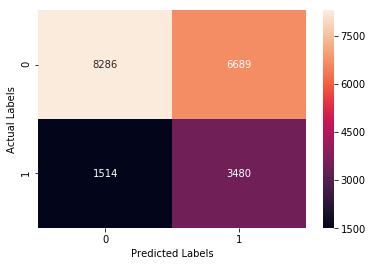

In [13]:
pred = model.predict(X)
cm = confusion_matrix(y, pred)

ax= pyplot.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')

## Plot the Feature Importance Tables

In [14]:
feature_importances = pd.DataFrame(model.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance',                                                                 ascending=False)
print(feature_importances)


                      importance
intervals|sum               0.33
bearing_rate|sum            0.08
distance_covered|max        0.08
MEAN_ROLL|std               0.06
MEAN_PITCH|std              0.06
VAR_GYRO_X|sum              0.04
VAR_GYRO_Z|sum              0.04
bearing_rate|var            0.03
car_acceleration|max        0.03
MEAN_PITCH|max              0.03
MEAN_ROLL|max               0.03
CROSSOVER_ROLL|sum          0.03
CROSSOVER_ACC_Z|sum         0.03
VAR_GYRO_Y|sum              0.02
bearing_rate|max            0.02
CROSSOVER_ACC_X|sum         0.02
CROSSOVER_GYRO_X|sum        0.02
CROSSOVER_ACC_Y|sum         0.02
CROSSOVER_GYRO_Z|sum        0.01
CROSSOVER_GYRO_Y|sum        0.01
CROSSOVER_PITCH|sum         0.01


## Plot ROC AUC curve and calculate AUC using 10 fold Cross validation

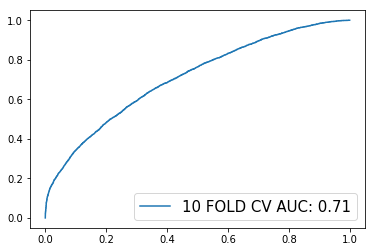

In [17]:
preds_cv = cross_val_predict(model, X, y, cv=10, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y, preds_cv[:, 1])
cv_auc = auc(fpr, tpr)

pyplot.plot(fpr,tpr,label="10 FOLD CV AUC: {:.2f}".format( cv_auc ))
pyplot.legend(loc=4, prop={'size': 15})
pyplot.show()


## Prediction of labels (ONLY RUN IF REQUIRED)
Labels are predicted using 10 fold cross validated predict and are written to the file named "predicted_values.csv"

In [18]:
predicted_labels = cross_val_predict(model, X, y, cv=10, method='predict')

np.savetxt("predicted_values.csv", predicted_labels, delimiter=",")